In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import re
import os
import shutil
import glob
import zipfile
import cv2

In [33]:
path= '골밀도 데이터/BoneAge/'
data_path = '골밀도 데이터/data/'

# xlsx파일과 zip파일 경로 추출
xls_path=glob.glob(path+"/*.xlsx")
zip_path=glob.glob(path+"/*.zip")

In [34]:
os.getcwd()

'/home/aiuser/junoflow/BA_project'

In [35]:
#zip파일 압축 해제 후 위치 변경
for zip in zip_path:
    zipfile.ZipFile(zip).extractall(data_path)

In [36]:
#이중 폴더 내 이미지 꺼내기
folder_path=glob.glob(data_path+"BA*")
for in_path in folder_path:
    tmp=os.listdir(in_path)
    for i in tmp:
        os.rename(in_path+"/"+i,data_path+str(int(i[0:3]))+i[3:])
    
    os.rmdir(in_path)

In [37]:
#xlsx파일 읽어서 합치기
df = pd.DataFrame()
for xlsx in xls_path:
    sub_df = pd.read_excel(xlsx)
    
    id = pd.DataFrame([int(re.findall(r'\d+', str(x))[0]) for x in sub_df["No."]])
    age = (sub_df["BA 1"] + sub_df['BA 2']) / 2
    gender = sub_df["성별"]-1
    
    tmp = pd.concat([id, age, gender], axis=1, ignore_index=True)
    df = pd.concat([df, tmp], axis=0, ignore_index=True)
    
df.columns=["ID","Age","Gender"]

In [39]:
#labeling 데이터 저장
df.to_excel(data_path+"clin_info.xlsx")

## 2. 이미지 전처리

In [52]:
data_path = '골밀도 데이터/data/'

In [53]:
img_path = data_path + str(df.ID[0]) +'_M.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img.shape #shape 확인

(1560, 1344)

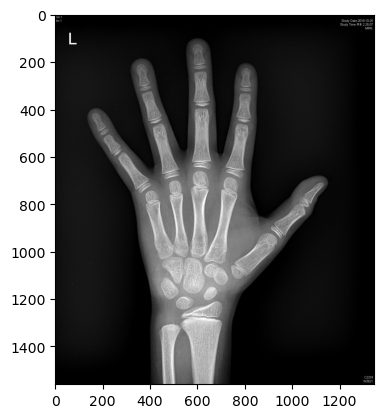

In [54]:
plt.imshow(img, 'gray')
plt.show()

__Resize__

In [55]:
#이미지 가로 세로 비율 확인
img.shape[0]/img.shape[1]

1.1607142857142858

In [58]:
#이미지 사이즈 재설정 (기존 1.25비율 유지)
resized_img=cv2.resize(img,(1024,1280))

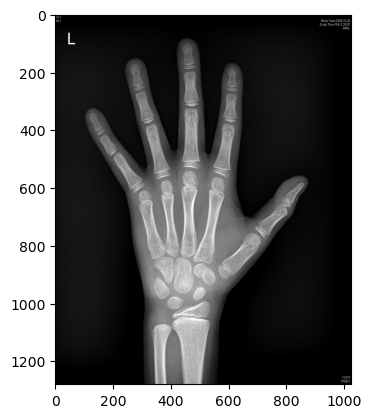

In [59]:
#resized 이미지 확인
plt.imshow(resized_img,"gray")

__Normalize__

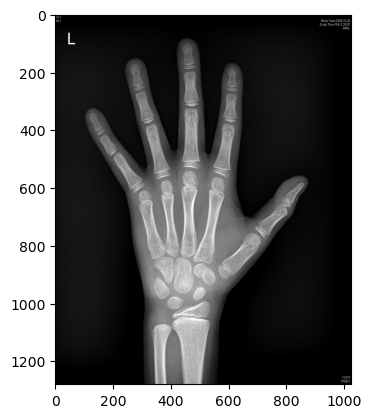

In [61]:
#이미지 min max 정규화
normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(normal_img,"gray")

__Denoise__

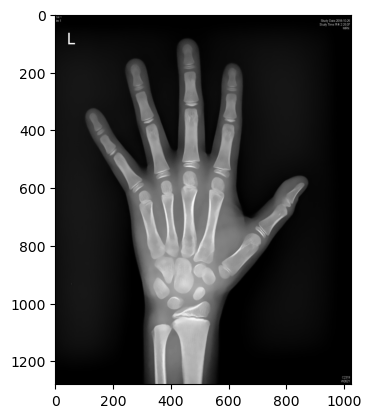

In [63]:
#이미지 노이즈 제거
    #제거 강도: 20
    #templateWindowSize :5
    #searchWindowSize : 15
denoise_img=cv2.fastNlMeansDenoising(normal_img, None, 20, 5, 15)
plt.imshow(denoise_img,"gray")

__Equalize__

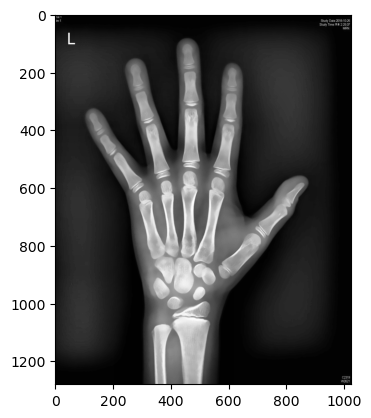

In [64]:
#이미지 평탄화
    #cv2.equalizeHist 사용시 전체 기준이므로 contrast가 날아가는 문제 발생
    #따라서 bin 구간 나누어 평탄화 가능한 clahe로 평탄화 수행
    #clipLimit: 2
    #tileGridSize: 5 x 5
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5,5))
equal_img=clahe.apply(denoise_img)
plt.imshow(equal_img,"gray")